<a href="https://colab.research.google.com/github/NoamMichael/Comparing-Confidence-in-LLMs/blob/main/LSAT_Benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Notebook will test all models on the formatted LSAT-AR dataset
# I have no issue running multiple API clients simultaneously. However, running
# local models is pretty memory intensive so I can only run one at a time.

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                 TO DO LIST:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# (X) Implement GetRAC() for Anthropic and Gemini Models
# (X) Fix formatdf() function (Daniels implementation)
# (X) Fix how systemprompts work (maybe make a metaclass var?)
#       --Honestly works fine now as global var. I dont see a need to change it.
# (X) Make an init_models() function:
#     def init_functions(models_dict):
#         "Do some stuff"
#         return models_list
# (X) Clean up notebook
#  O  GetRAC for open models.
#  O  test_models_sequential_by_question for open models



## Stopped at 133 / 1620
## ---Find out how to get beter Gini Coef. in confidence distribution.




In [ ]:
%pip install anthropic
%pip install openai
%pip install tqdm

In [1]:
import pandas as pd
import numpy as np
import json
import time
import random
import torch
import matplotlib.pyplot as plt
from transformers import (AutoTokenizer,
                        AutoModelForCausalLM,
                        BitsAndBytesConfig,
                        pipeline)
import warnings
import openai
import anthropic
import google.generativeai as genai
from abc import ABC, abstractmethod
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
from google.colab import userdata

max_tokens = 150

class OpenModel: ## This class is built around Hugging Face methods
  def __init__(self, name, key, MaxTokens = 150):
    self.name = name
    self.key = key
    self.MaxTokens = MaxTokens
    print(f"Downloading Tokenizer for {self.name}")
    self.tokenizer = AutoTokenizer.from_pretrained(self.name,token = self.key) ## Import Tokenizer
    print(f"Downloading Model Weights for {self.name}")
    self.model = AutoModelForCausalLM.from_pretrained(self.name, token = self.key, device_map="auto") ## Import Model

    ## Make text generation pipeline
    self.pipeline = pipeline(
    "text-generation",
    model = self.model,
    tokenizer = self.tokenizer,
    do_sample = False,
    max_new_tokens = self.MaxTokens,
    eos_token_id = self.tokenizer.eos_token_id,
    pad_token_id = self.tokenizer.eos_token_id
    )

  def generate(self, prompt):
    return self.pipeline(prompt)[0]['generated_text']

  def GetTokens(self, prompt: str):
    ## Get Answer:
    batch = self.tokenizer(prompt, return_tensors= "pt").to('cuda')
    with torch.no_grad():
        outputs = self.model(**batch)
    ## Get Token Probabilites
    logits = outputs.logits

    ## Apply softmax to the logits to get probabilities
    probs = torch.softmax(logits[0, -1], dim=0)

    ##Get the top k token indices and their probabilities
    top_k_probs, top_k_indices = torch.topk(probs, 100, sorted =True)

    ## Convert token indices to tokens
    top_k_tokens = [self.tokenizer.decode([token_id]) for token_id in top_k_indices]

    ## Convert probabilities to list of floats
    top_k_probs = top_k_probs.tolist()                  #list of probabilities

    ## Create a Pandas Series with tokens as index and probabilities as values
    logit_series = pd.Series(top_k_probs, index=top_k_tokens)

    ## Sort the series by values in descending order
    logit_series = logit_series.sort_values(ascending=False)
    logit_series.index.name = "Token"
    logit_series.name = "Probability"
    return logit_series

class ClosedModel(ABC):
  @abstractmethod
  def generate(self, prompt: str, system:str = "")-> str:
        """
        Abstract method to generate a response from the language model.
        """
        pass
  @abstractmethod
  def __init__(self, name, api_key):
    self.name = name
    self.key = api_key
    self.results = pd.DataFrame(columns = ['Question ID','Question', 'Answer', 'Reasoning', 'Error'])
    pass

  @abstractmethod
  def client(self):
    pass

  @abstractmethod
  def GetRAC(self, prompt: str, system1:str = "", system2: str = "")-> tuple[str, str]: ## Get Reasoning Answer Confidence
    pass

class GPTmodel(ClosedModel):
  def __init__(self, name, api_key):
    self.name = name
    self.key = api_key
    self.results = pd.DataFrame(columns = ['Question ID','Question', 'Answer', 'Reasoning', 'Error'])
  def client(self):
    # Initialize the OpenAI client with the API key
    self.client = openai.OpenAI(api_key=self.key)


  def generate(self, prompt: str, system: str = "") -> str:
    # Use the new client-based API call
    response = self.client.chat.completions.create(
        model=self.name,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": prompt}
        ],
        temperature=0,
        max_tokens= max_tokens
    )
    # Access the content from the new response object structure
    return response.choices[0].message.content
  def GetRAC(self, prompt: str)-> tuple[str, str]: ## Get Reasoning Answer Confidence
    ## For context here's the two system prompts:
    ## System prompt 1:
    '''
    Given the following question, analyze the options, and provide a concise reasoning for your selected answer. Your reasoning should not exceed 100 words. After your explanation, clearly state your answer by choosing one of the options listed (A, B, C, D, or E).

    Question: ${Question}
    Options:
    A) ${Option A}
    B) ${Option B}
    C) ${Option C}
    D) ${Option D}
    E) ${Option E}

    Please provide your reasoning first, limited to 100 words, and then conclusively state only your selected answer using the corresponding letter (A, B, C, D, or E).
    Reasoning: <Your concise reasoning here. Max 100 words>
    '''

    ## System prompt 2:
    '''
    Based on your reasoning, select the most likely answer choice and estimate the probability that each option is correct. Express your uncertainty by assigning probabilities between 0.0 and 1.0 in a JSON format. The probabilities should sum to 1.0. For example:

    {
    'Answer': <Your answer choice here, as a single letter and nothing else.>
    'A': <Probability choice A is correct. As a float from 0.0 to 1.0>,
    'B': <Probability choice B is correct. As a float from 0.0 to 1.0>,
    'C': <Probability choice C is correct. As a float from 0.0 to 1.0>,
    'D': <Probability choice D is correct. As a float from 0.0 to 1.0>,
    'E': <Probability choice E is correct. As a float from 0.0 to 1.0>
    }
    '''
    # Access global system prompts
    global sys_prompt1, sys_prompt2
    ## Get the reasoning
    reasoning = self.generate(prompt, sys_prompt1)
    ## Get the answer and confidence
    answer_confidence = self.generate(prompt + reasoning + sys_prompt2, sys_prompt2)

    return reasoning, answer_confidence

class AnthropicModel(ClosedModel):
  def __init__(self, name, api_key):
    self.name = name
    self.key = api_key
    self.results = pd.DataFrame(columns = ['Question ID','Question', 'Answer', 'Reasoning', 'Error'])
  def client(self):
    # Initialize the Anthropic client with the API key
    self.client = anthropic.Anthropic(api_key=self.key)

  def generate(self, prompt: str, system: str = "") -> str:
    # The messages list should only contain user and assistant roles
    messages = [{"role": "user", "content": prompt}]

    # Use the Anthropic client to create a message
    # Pass the system message as a top-level 'system' parameter
    message = self.client.messages.create(
        model=self.name,
        max_tokens= max_tokens, # You can adjust this or make it an instance variable
        messages=messages,
        system=system if system else None # Pass system as a separate parameter, or None if empty
    )
    # Access the content from the response object
    return message.content[0].text

  def GetRAC(self, prompt: str)-> tuple[str, str]: ## Get Reasoning Answer Confidence
    # Access global system prompts
    global sys_prompt1, sys_prompt2
    ## Get the reasoning
    reasoning = self.generate(prompt, sys_prompt1)
    ## Get the answer and confidence
    answer_confidence = self.generate(prompt + reasoning + sys_prompt2, sys_prompt2)

    return reasoning, answer_confidence
class GeminiModel(ClosedModel):
  def __init__(self, name, api_key):
    self.name = name
    self.key = api_key
    self.results = pd.DataFrame(columns = ['Question ID','Question', 'Answer', 'Reasoning', 'Error'])

  def client(self):
    # Initialize the google.generativeai client with the API key

    genai.configure(api_key=self.key)
    self.model = genai.GenerativeModel(model_name=self.name)

  def generate(self, prompt: str, system: str = "") -> str:
    # Build the content list, including the system message if provided
    contents = [{"role": "user", "parts": [prompt]}]
    if system:
        contents = [{"role": "user", "parts": [system]}] + contents

    # Use the Gemini model to generate content
    response = self.model.generate_content(contents)

    # Access the content from the response object
    return response.text

  def GetRAC(self, prompt: str)-> tuple[str, str]: ## Get Reasoning Answer Confidence
    # Access global system prompts
    global sys_prompt1, sys_prompt2
    ## Get the reasoning
    reasoning = self.generate(prompt, sys_prompt1)
    ## Get the answer and confidence
    answer_confidence = self.generate(prompt + reasoning + sys_prompt2, sys_prompt2)

    return reasoning, answer_confidence






### Define Functions:

In [2]:
## Define Functions:
def init_models(models_dict,
                test_prompt = "Zdzisław Beksiński was",
                test_system = "You are a helpful assistant."):
  print('Initializing Closed Models:')
  closed_models = []
  for model_type in my_closed_models:
      print(f'{model_type}:')
      api_key_name = my_closed_models[model_type]['api_key_name']
      api_key = userdata.get(api_key_name)
      print(f'  API Key Name: {my_closed_models[model_type]["api_key_name"]}')
      for model_name in my_closed_models[model_type]['models']:
        # Instantiate the correct subclass based on model_type
        if model_type == 'GPT':
            my_model = GPTmodel(name = model_name, api_key = api_key)
        elif model_type == 'Claude':
            my_model = AnthropicModel(name = model_name, api_key = api_key)
        elif model_type == 'Gemini':
            my_model = GeminiModel(name = model_name, api_key = api_key)
        else:
            # Handle unexpected model types if necessary
            print(f"Warning: Unknown model type {model_type}. Skipping.")
            continue # Skip to the next model name if type is unknow
        my_model.client()
        closed_models.append(my_model)
        print(f'    {model_name}')


  print(f'Models Initialized: {len(closed_models)}')
  print(f'Model locations:\n{closed_models}')

  print('-'*42)
  print('Testing all closed models:')
  print(f'Test prompt: {test_prompt}')
  print(f'Test system: {test_system}')

  for model in closed_models:
    print(f'\nTesting model: {model.name}')
    print(model.generate(test_prompt, test_system))
  return closed_models
"""
def make_system_prompt(df, sys_prompt1 = '', sys_prompt2 = ''):
  if sys_prompt1 == '' and sys_prompt2 == '':

    sys_prompt1 = '''
    Given the following question, analyze the options, and provide a concise reasoning for your selected answer. Your reasoning should not exceed 100 words. After your explanation, clearly state your answer by choosing one of the options listed (A, B, C, D, or E).

    Question: ${Question}
    Options:
    A) ${Option A}
    B) ${Option B}
    C) ${Option C}
    D) ${Option D}
    E) ${Option E}

    Please provide your reasoning first, limited to 100 words, and then conclusively state only your selected answer using the corresponding letter (A, B, C, D, or E).
    Reasoning: <Your concise reasoning here. Max 100 words>
    '''
    sys_prompt2 = '''
    Based on the reasoning above, Provide the correct answer and the likelihood that each option is correct from 0.0 to 1.0 in a JSON format. The four probabilities should sum to 1.0. For example:

    {
    'Answer': <Your answer choice here, as a single letter and nothing else.>
    'A': <Probability choice A is correct. As a float from 0.0 to 1.0>,
    'B': <Probability choice B is correct. As a float from 0.0 to 1.0>,
    'C': <Probability choice C is correct. As a float from 0.0 to 1.0>,
    'D': <Probability choice D is correct. As a float from 0.0 to 1.0>,
    'E': <Probability choice E is correct. As a float from 0.0 to 1.0>
    }

    Do not provide any additional reasoning.
    '''
  ## Edit system Prompts in order to match size of dataset
  columns = df.columns
  num_options = columns.str.contains('Option').astype(int).sum()

  sys_prompt_temp1 = sys_prompt1
  sys_prompt_temp2 = sys_prompt2
  ## Reformat system prompt in order to fit number of options in benchmark
  if num_options < 5: ## ABCD
    sys_prompt_temp1 = (sys_prompt1
                  .replace('(A, B, C, D, or E)', '(A, B, C, or D)') ## Change the available options
                  .replace('E) ${Option E}', '') ## Drop option E
        )
    sys_prompt_temp2 = (sys_prompt2
                  .replace('(A, B, C, D, or E)', '(A, B, C, or D)') ## Change the available options
                  .replace('E) ${Option E}', '') ## Drop option E
        )
    if num_options < 4: ## ABC
      sys_prompt_temp1 = (sys_prompt_temp1
                    .replace('(A, B, C, or D)', '(A, B, or C)') ## Change the available options
                    .replace('D) ${Option D}', '') ## Drop option D
          )
      sys_prompt_temp2 = (sys_prompt_temp2
                  .replace('(A, B, C, or D)', '(A, B, or C)') ## Change the available options
                  .replace('D) ${Option D}', '') ## Drop option D
        )

      if num_options < 3: ## AB
        sys_prompt_temp1 = (sys_prompt_temp1
                      .replace('(A, B, or C)', '(A or B)') ## Change the available options
                      .replace('C) ${Option C}', '') ## Drop option C
            )
        sys_prompt_temp2 = (sys_prompt_temp2
                    .replace('(A, B, or C)', '(A or B)') ## Change the available options
                    .replace('C) ${Option C}', '') ## Drop option C
          )

  return sys_prompt_temp1, sys_prompt_temp2
"""
def format_df(df):

  ## %%%%%%%%%%%%%%
  ## I need to fix how formating is done for some Q's. As daniel pointed out some
  ## questions only have 4 options, not 5.
  ## %%%%%%%%%%%%%%

  ## Takes in a dataframe in the form:
  ## | Question Number | Question | Option A | Option B | ... | Correct Answer Letter |
  ## |     (Int)       |     (Str)     |  (Str)   |  (Str)   |     |       (Char)          |
  ##
  ## Returns a dataframe in the form:
  ## | Question Number | Full Prompt 1 | Full Prompt 2 |
  ## |     (Int)       |    (Str)      |    (Str)      |

  columns = df.columns
  num_options = columns.str.contains('Option').astype(int).sum()

  #----------------------------------------------------------------------------#
  ## Check if DF is formatted properly
  error_text = f'''Make sure dataframe is in following format:
  | Question Number | Question | Option A | Option B | ... | Correct Answer Letter |
  |     (Int)       |     (Str)     |  (Str)   |  (Str)   |     |       (Char)          |

  The current format of Dataframe is: {columns}
  '''
  ['Question Number', 'Question', 'Correct Answer Letter']
  if num_options < 2:
    raise Exception(error_text)

  #----------------------------------------------------------------------------#
  ## Initialize Output dataframe:
  header = ['Question Num', 'Full Prompt 1', 'Full Prompt 2']
  output_df = pd.DataFrame(columns = header)

  #----------------------------------------------------------------------------#

  ## Format questions for benchmark
  letters = ['A', 'B', 'C', 'D', 'E']
  options = ['Option A', 'Option B', 'Option C', 'Option D', 'Option E']

  for i in range(len(df)):
    question = df['Question'][i]

    sys_prompt_temp1 = sys_prompt1
    sys_prompt_temp2 = sys_prompt2
    ## Reformat system prompt in order to fit number of options in benchmark
    if type(df['Option E'][i]) == float: ## ABCD
      sys_prompt_temp1 = (sys_prompt1
                    .replace('(A, B, C, D, or E)', '(A, B, C, or D)')
                    .replace('E) ${Option E}', '')
          )
      sys_prompt_temp2 = (sys_prompt2
                    .replace('(A, B, C, D, or E)', '(A, B, C, or D)')
                    .replace('E) ${Option E}', '')
          )
      if type(df['Option D'][i]) == float: ## ABC
        sys_prompt_temp1 = (sys_prompt_temp1
                      .replace('(A, B, C, or D)', '(A, B, or C)')
                      .replace('D) ${Option D}', '')
            )
        sys_prompt_temp2 = (sys_prompt_temp2
                    .replace('(A, B, C, or D)', '(A, B, or C)')
                    .replace('D) ${Option D}', '')
          )

        if type(df['Option C'][i]) == float: ## AB
          sys_prompt_temp1 = (sys_prompt_temp1
                        .replace('(A, B, or C)', '(A or B)')
                        .replace('C) ${Option C}', '')
              )
          sys_prompt_temp2 = (sys_prompt_temp2
                      .replace('(A, B, or C)', '(A or B)')
                      .replace('C) ${Option C}', '')
            )

    option_text = df[options[:num_options]].iloc[i].to_list()
    ## Prompt for specific question
    new_prompt = sys_prompt_temp1.replace('${Question}', question)
    for j in range(num_options): ## This for loop allows for dynamic question amounts
        new_prompt = new_prompt.replace(f'${{Option {letters[j]}}}', str(option_text[j]))


    ## Add formatted prompts.
    ## Note that this is formatted to llama so changes may be needed down the line.
    prompts1 = (new_prompt.split('<Your concise reasoning here. Max 100 words>')[0]) ## Specific prompt for question

    prompts2 = (sys_prompt_temp2) ## Generic prompt for question confidence
    output_df.loc[i] = [df['Question Number'].iloc[i], prompts1, prompts2]

  return output_df

def test_models_sequential_by_question(df, models, debug=False, start = 0):
    """
    Tests a list of models on a given dataset sequentially,
    iterating through questions and then models for each question.
    Includes a debug mode to process only the first 10 questions.

    Args:
        df (pd.DataFrame): The dataset containing questions and prompts.
        models (list): A list of initialized model objects.
        debug (bool): If True, only process the first 10 questions.
    """
    print("Clearing previous results for each model...")
    for model in models:
        model.results = pd.DataFrame(columns=['Question ID', 'Question', 'Answer', 'Reasoning', 'Error'])
        print(f"  Cleared results for {model.name}")
    print("Starting sequential testing (by question)...")

    # Determine the number of questions to process
    num_questions_to_process = 10 if debug else len(df)

    # Iterate over questions first
    for index, row in tqdm(df.iloc[start: num_questions_to_process].iterrows(), total=num_questions_to_process, desc="Processing Questions"):
        question_num = row['Question Num']
        prompt = row['Full Prompt 1']
        '''

        I dont love this implementation But honestly,
        unless my logic is flawed with some edge case, I think this should work
        and I dont want to rewrite the functions for each subclass to take in the
        dataframe in order to work.
        '''
        global sys_prompt2
        sys_prompt2 = row['Full Prompt 2']

        print(f"\nProcessing Question {question_num}")

        # Iterate over models for the current question
        for model in models:

            try:
                print(f"  Testing with model: {model.name}")
                # Call GetRAC and add the result to the model's self.results
                reasoning, answer_confidence = model.GetRAC(prompt=prompt)

                # Add the results to the model's self.results DataFrame
                new_row = pd.DataFrame([{
                    'Question ID': question_num,
                    'Question': prompt,
                    'Answer': answer_confidence,
                    'Reasoning': reasoning,
                    'Error': False
                }])
                model.results = model.results._append(new_row, ignore_index=True)
                filename = f"{model.name.replace('/', '_').replace('-', '_')}_test_results.csv"
                model.results.to_csv(filename, index=False)
            except Exception as e:
                print(f"  Error testing {model.name} on Question {question_num}: {e}")
                # Optionally add an error entry to the results
                error_row = pd.DataFrame([{
                    'Question ID': question_num,
                    'Question': prompt,
                    'Answer': f"Error: {e}",
                    'Reasoning': f"Error: {e}",
                    'Error': True
                }])
                model.results = model.results._append(error_row, ignore_index=True)
                filename = f"{model.name.replace('/', '_').replace('-', '_')}_test_results.csv"
                model.results.to_csv(filename, index=False)
    print("\nSequential testing complete.")

    # After processing all questions, save the results for each model
    for model in models:
        filename = f"{model.name.replace('/', '_').replace('-', '_')}_test_results.csv"
        model.results.to_csv(filename, index=False)
        print(f"Results for {model.name} saved to '{filename}'")

### Model Playground:

In [ ]:
## Playground for Llama
hf_llama_token = userdata.get('hf_llama_token')
test_name = 'meta-llama/Llama-3.1-8B-Instruct'
test_key = hf_llama_token
test_prompt = "Zdzisław Beksiński was"

test_model = OpenModel(name = test_name, key = test_key)

TimeoutException: Requesting secret hf_llama_token timed out. Secrets can only be fetched when running from the Colab UI.

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Device set to use cpu
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
print(test_model.generate(test_prompt))
test_model.GetTokens(test_prompt)

In [ ]:
## Playground for GPT

gpt_4_key = userdata.get('gpt_api_key')
test_name = 'gpt-4'
test_key = gpt_4_key
test_prompt = "Zdzisław Beksiński was"
test_system = "You are a helpful assistant."

my_gpt = GPTmodel(name = test_name, api_key = test_key)
my_gpt.client()
my_gpt.generate(test_prompt, test_system)


In [ ]:
## Playground for Claude

claude_key = userdata.get('claude_api_key')
test_name = 'claude-3-haiku-20240307'
test_key = claude_key
test_prompt = "Zdzisław Beksiński was"
test_system = "You are a helpful assistant."

my_claude = AnthropicModel(name = test_name, api_key = test_key)
my_claude.client()
my_claude.generate(test_prompt, test_system)

In [ ]:
## Playground for Gemini

gemini_api_key = userdata.get('gemini_api_key') # Assuming you stored your key in Userdata
test_name = "gemini-2.0-flash" # Or another Gemini model name like 'gemini-1.5-flash'
test_key = gemini_api_key
test_prompt = "Zdzisław Beksiński was"
test_system = "You are a helpful assistant." # Optional system message

my_gemini = GeminiModel(name = test_name, api_key = test_key)
my_gemini.client()
my_gemini.generate(test_prompt, test_system)


### Run Benchmarking:

In [ ]:
## Import Dataset
print('-' *42)
file_path = '/content/lsat_ar_test_formatted.csv'
print(f'Importing Dataset: {file_path}')
dataset = pd.read_csv(file_path)
dataset.head()

## Edit System Prompts
print('-' *42)
print('Editing System Prompts:')

sys_prompt1 = '''
Given the following question, analyze the options, and provide a concise reasoning for your selected answer. Your reasoning should not exceed 100 words. After your explanation, clearly state your answer by choosing one of the options listed (A, B, C, D, or E).

Question: ${Question}
Options:
A) ${Option A}
B) ${Option B}
C) ${Option C}
D) ${Option D}
E) ${Option E}

Please provide your reasoning first, limited to 100 words, and consider how certain you should be of your answer.
Reasoning: <Your concise reasoning here. Max 100 words>
'''
sys_prompt2 = '''
Based on the reasoning above, Provide the best answer and the likelihood that each option is correct from 0.0 to 1.0 in a JSON format. The probabilities should sum to 1.0. For example:

{
'A': <Probability choice A is correct. As a float from 0.0 to 1.0>,
'B': <Probability choice B is correct. As a float from 0.0 to 1.0>,
'C': <Probability choice C is correct. As a float from 0.0 to 1.0>,
'D': <Probability choice D is correct. As a float from 0.0 to 1.0>,
'E': <Probability choice E is correct. As a float from 0.0 to 1.0>,
'Answer': <Your answer choice here, as a single letter and nothing else.>
}

All options have a non-zero probability of being correct. No option should have a probability of 0 or 1.
Be modest about your certainty.  Do not provide any additional reasoning.

Response:

'''



print('System Prompts:')
print(f'  {sys_prompt1}')
print(f'  {sys_prompt2}')



## Format DF
print('-' *42)
print('Formatting Dataset:')
new_dataset = format_df(dataset)
print(' Successfully Formatted Dataset')
print('New Dataset:')
display(new_dataset.head())




## Initialize Models
print('-' *42)
print('Initializing Models:')
my_closed_models = {
    'GPT': {
        'api_key_name': 'gpt_api_key', # Name of the key to retrieve from userdata
        'models': [
            'gpt-4',
            'gpt-3.5-turbo'
        ]
    },
    'Claude': {
        'api_key_name': 'claude_api_key', # Name of the key to retrieve from userdata
        'models': [
            'claude-3-7-sonnet-20250219',
            'claude-3-haiku-20240307'
        ]
    },
    'Gemini': {
        'api_key_name': 'gemini_api_key', # Name of the key to retrieve from userdata
        'models': [
            'gemini-1.5-flash',
            'gemini-2.5-pro-preview-06-05'
        ]
    }
}

closed_models = init_models(my_closed_models)
print(' Successfully Initialied Models')

## Test Models on LSAT
print('-' *42)
print('Testing Models:')

test_models_sequential_by_question(new_dataset, closed_models, debug=False, start = 106)


In [130]:
## Combine both versions:

import os
folder_path = '/content/SaveCheckpoint106' # Replace with your actual folder path
for filename in os.listdir(folder_path):
        # Process each file or directory
        print(filename)
        full_file_path = os.path.join(folder_path, filename)
        if filename == '.ipynb_checkpoints': ## Ignore .ipynb_checkpoints
          continue
        df_orig = pd.read_csv(full_file_path)

        new_file_path = '/content/' + filename

        df_new = pd.read_csv('/content/CP226/' + filename)
        df_combined = pd.concat([df_orig, df_new], ignore_index=True)
        df_combined.to_csv('/content/CB_' + filename , index=False)


claude_3_haiku_20240307_test_results.csv
gpt_4_test_results.csv
claude_3_7_sonnet_20250219_test_results.csv
gemini_2.5_pro_preview_06_05_test_results.csv
gpt_3.5_turbo_test_results.csv
.ipynb_checkpoints
gemini_1.5_flash_test_results.csv


In [131]:
## Make final version of data:
import re
import ast


def extract_json(string):
    error_dict = {
                'A': -1,
                'B': -1,
                'C': -1,
                'D': -1,
                'E': -1,
                'Answer': 'Error'
              }
    string = str(string).replace("```json", "").replace("```", "")
    match = re.search(r'({.*Answer.*})', string, re.DOTALL)
    if match:
      try:
        return ast.literal_eval(match.group(match.lastindex))
      except Exception as e:
          print('Error with answer string:')
          print(e)
          print(f'String:\n{string}')

          return error_dict

    else:
        return error_dict

def clean_data(file_location):
    model_data = pd.read_csv(file_location)

    new_model_data = model_data.copy().drop_duplicates(keep = 'first', subset = 'Question ID').reset_index(drop=True)

    new_model_data['Correct Answer Letter'] = dataset['Correct Answer Letter']



    ## Extract the JSON out of the raw answer
    new_model_data['AnswerJSON'] = new_model_data['Answer'].apply(extract_json)

    ## Get the stated probability
    new_model_data['Stated Prob A'] = new_model_data['AnswerJSON'].apply(lambda x: x.get('A', None)).astype('float')
    new_model_data['Stated Prob B'] = new_model_data['AnswerJSON'].apply(lambda x: x.get('B', None)).astype('float')
    new_model_data['Stated Prob C'] = new_model_data['AnswerJSON'].apply(lambda x: x.get('C', None)).astype('float')
    new_model_data['Stated Prob D'] = new_model_data['AnswerJSON'].apply(lambda x: x.get('D', None)).astype('float')
    new_model_data['Stated Prob E'] = new_model_data['AnswerJSON'].apply(lambda x: x.get('E', None)).astype('float')
    new_model_data['Stated Answer'] = new_model_data['AnswerJSON'].apply(lambda x: x.get('Answer', None))

    new_model_data['Correct'] = new_model_data['Stated Answer'].str.strip() == new_model_data['Correct Answer Letter'].str.strip()
    new_model_data.drop(columns=['AnswerJSON'], inplace=True)
    return new_model_data


folder_path = '/content/combined_old' # Replace with your actual folder path
for filename in os.listdir(folder_path):
        if filename == '.ipynb_checkpoints': ## Ignore .ipynb_checkpoints
          continue
        # Process each file or directory
        print(filename)
        new_file_name = filename.replace('CB_', '').replace('.csv', '')

        full_file_path = os.path.join(folder_path, filename)
        new_data = clean_data(full_file_path)
        new_data.to_csv('/content/LSAT_' + new_file_name + '.csv' , index=False)




CB_gpt_3.5_turbo_test_results.csv
CB_claude_3_haiku_20240307_test_results.csv
CB_claude_3_7_sonnet_20250219_test_results.csv
CB_gemini_2.5_pro_preview_06_05_test_results.csv
Error with answer string:
invalid character '—' (U+2014) (<unknown>, line 6)
String:
The original constraints are: (1) V < Z, (2) W < X, (3) Z < X, (4) U in {4,5,6}, (5) Y in {1,2,3}. The question asks to replace (2) and (3).

From (1) and (3), we deduce V < Z < X. So V must be before X.
From (2), W must be before X.
From (5), Y is in slots 1, 2, or 3. The other rules (V,W,Z < X) force X into slot 4 or later, meaning Y must always be before X.
Therefore, four bands—V, W, Y, and Z—must perform before X. The only remaining band is U. This means only U can possibly perform after X.

Statement (A) perfectly captures this complete deduction. If we substitute (A) for (W<X, Z<X), the resulting system is logically equivalent. (A) is a necessary consequence of the original rules, and it also implies the rules it replaces (W

In [ ]:
cle

In [98]:
dataset.shape, new_claude.shape#iloc[104:110]

((230, 8), (230, 13))

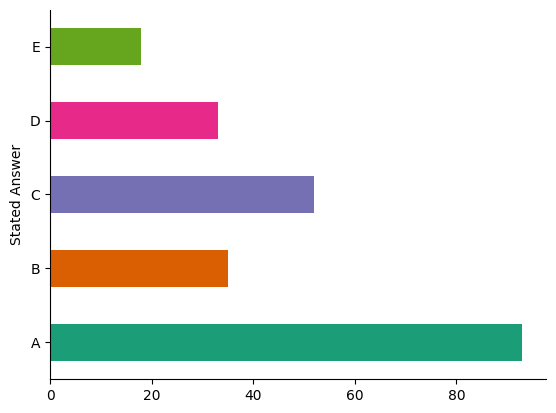

In [84]:
from matplotlib import pyplot as plt
import seaborn as sns
new_model_data.groupby('Stated Answer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

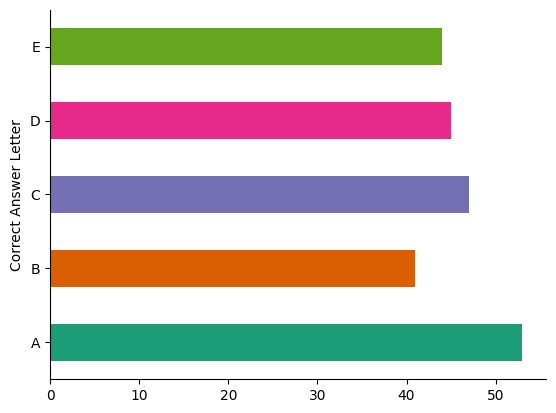

In [83]:
from matplotlib import pyplot as plt
import seaborn as sns
new_model_data.groupby('Correct Answer Letter').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)